In [0]:
%pip install markdown
%pip install lxml
%pip install beautifulsoup4
%pip install geopandas
%pip install shapely

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%sh
ls /dbfs/databricks-datasets/airlines

README.md
_SUCCESS
part-00000
part-00001
part-00002
part-00003
part-00004
part-00005
part-00006
part-00007
part-00008
part-00009
part-00010
part-00011
part-00012
part-00013
part-00014
part-00015
part-00016
part-00017
part-00018
part-00019
part-00020
part-00021
part-00022
part-00023
part-00024
part-00025
part-00026
part-00027
part-00028
part-00029
part-00030
part-00031
part-00032
part-00033
part-00034
part-00035
part-00036
part-00037
part-00038
part-00039
part-00040
part-00041
part-00042
part-00043
part-00044
part-00045
part-00046
part-00047
part-00048
part-00049
part-00050
part-00051
part-00052
part-00053
part-00054
part-00055
part-00056
part-00057
part-00058
part-00059
part-00060
part-00061
part-00062
part-00063
part-00064
part-00065
part-00066
part-00067
part-00068
part-00069
part-00070
part-00071
part-00072
part-00073
part-00074
part-00075
part-00076
part-00077
part-00078
part-00079
part-00080
part-00081
part-00082
part-00083
part-00084
part-00085
part-00086
part-00087
part-00088
pa

In [0]:
%python
import markdown as md


class Markdown:
    """Markdown class for properly rendering Markdown in Databricks notebook"""
    def __init__(self, markdown_text):
        self.html = md.markdown(markdown_text)
    def _repr_html_(self):
        return self.html
    

with open("/dbfs/databricks-datasets/airlines/README.md", "r") as f:
    readme_content = f.read()

Markdown(readme_content)

================================================
Airline On-Time Statistics and Delay Causes
================================================ 
 Background 
 The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released. 
 FAQ Information is available at http://www.rita.dot.gov/bts/help_with_data/aviation/index.html 
 Data Source 
 http://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp 
 Usage Restrictions 
 The data is released under the Freedom of Information act. More information can be found at http://www.fas.org/sgp/foia/citizen.html

## Describe Data
- Directory Size
- File Size
- File Type
- Rows

In [0]:
%sh
du --human-readable /dbfs/databricks-datasets/airlines/                  # size of directory
ls -s --human-readable /dbfs/databricks-datasets/airlines/part-00000     # size of 1 data-file
wc --lines /dbfs/databricks-datasets/airlines/part-00000                 # rows in 1 data-file
ls /dbfs/databricks-datasets/airlines/part-* | wc --lines                # count of data-files
file /dbfs/databricks-datasets/airlines/part-00000                       # data-file type
echo
head --lines 5 /dbfs/databricks-datasets/airlines/part-00000             # sample of data-file 1; headers
echo
head --lines 5 /dbfs/databricks-datasets/airlines/part-00002             # sample of data-file 2; no headers

121G	/dbfs/databricks-datasets/airlines/
65M /dbfs/databricks-datasets/airlines/part-00000
645919 /dbfs/databricks-datasets/airlines/part-00000
1920
/dbfs/databricks-datasets/airlines/part-00000: CSV text

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed
1987,10,14,3,741,730,912,849,PS,1451,NA,91,79,NA,23,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA,YES,YES
1987,10,15,4,729,730,903,849,PS,1451,NA,94,79,NA,14,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA,YES,NO
1987,10,17,6,741,730,918,849,PS,1451,NA,97,79,NA,29,11,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA,YES,YES
1987,10,18,7,729,730,847,849,PS,1451,NA,78,79,NA,-2,-1,SAN,SFO,447,NA,NA,0,NA,0,NA,NA,NA,NA,NA,NO,NO

1987,12,19,6,1330,1305,1452,1445,AS,84,NA,82,100,NA,7,25,P

In [0]:
%sh
ls /dbfs/databricks-datasets/airlines/part-* | tail -2       # what's the 2nd to last file, which maybe has more data than the last, so I can use it for demo?

/dbfs/databricks-datasets/airlines/part-01918
/dbfs/databricks-datasets/airlines/part-01919


In [0]:
%python
from pyspark.sql import SparkSession
import pandas as pd


spark = SparkSession.builder.getOrCreate()

df_first = spark.read.csv('/databricks-datasets/airlines/part-00000', sep=',', header=True, inferSchema=True)                           # grab headers & infer schema from first file
df_first_ten = spark.read.csv('/databricks-datasets/airlines/part-0000*', sep=',', header=False, schema=df_first.schema).na.drop()      # using schema, read in first 10 CSVs & drop the bogus header row; takes a min
# df_all = spark.read.csv('/databricks-datasets/airlines/part-*', sep=',', header=False, schema=df_first.schema).na.drop()                # using schema, read in all CSVs & drop the bogus header row; takes 10min+
df_demo = spark.read.csv('/databricks-datasets/airlines/part-01918', sep=',', header=True, schema=df_first.schema)                      # using schema, read in 2nd to last CSV for demo work; presumably, more likely to have data for all fields

df_first_ten.count()

Out[5]: 6489240

In [0]:
%sh
# sanity check; this ties out with above df_first_ten + 1 header row
wc --lines /dbfs/databricks-datasets/airlines/part-0000* | grep total

  6489241 total


## Describe Data
- Schema

In [0]:
%python
df_demo.printSchema()
df_demo.display()
# Doesn't tell us that perhaps, certain airlines/cariers are worst offenders. I would suggest integrating this additional information for more insights

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,IsArrDelayed,IsDepDelayed
2008,10,22,3,1641,1643,1930,1957,CO,1820,N24736,109,134,87,-27,-2,IAH,ATL,689,7,15,0,null,0,NA,NA,NA,NA,NA,NO,NO
2008,10,22,3,1528,1525,1654,1701,CO,1821,N38727,206,216,185,-7,3,IAH,SNA,1347,6,15,0,null,0,NA,NA,NA,NA,NA,NO,YES
2008,10,22,3,823,825,1737,1648,CO,1827,N37274,374,323,339,49,-2,SAN,EWR,2425,18,17,0,null,0,0,0,49,0,0,YES,NO
2008,10,22,3,2145,2145,600,554,CO,1829,N57864,315,309,298,6,0,SFO,EWR,2565,8,9,0,null,0,NA,NA,NA,NA,NA,YES,NO
2008,10,22,3,NA,1910,NA,2239,CO,1830,null,NA,149,NA,NA,NA,IAH,PBI,956,NA,NA,1,A,0,NA,NA,NA,NA,NA,YES,YES
2008,10,22,3,626,630,800,802,CO,1831,N77510,154,152,137,-2,-4,PBI,IAH,956,7,10,0,null,0,NA,NA,NA,NA,NA,NO,NO
2008,10,22,3,1215,1140,1646,1618,CO,1832,N21723,211,218,172,28,35,IAH,LGA,1416,4,35,0,null,0,0,0,28,0,0,YES,YES
2008,10,22,3,1154,1200,1508,1455,CO,1833,N13716,254,235,210,13,-6,LGA,IAH,1416,8,36,0,null,0,NA,NA,NA,NA,NA,YES,NO
2008,10,22,3,711,715,830,810,CO,1841,N14358,79,55,63,20,-4,IAH,AUS,140,3,13,0,null,0,0,0,20,0,0,YES,NO
2008,10,22,3,1440,1437,1810,1825,CO,1844,N33266,150,168,130,-15,3,IAH,CLE,1091,6,14,0,null,0,NA,NA,NA,NA,NA,NO,YES


In [0]:
%python
df_demo.createOrReplaceTempView("airlines")

## [Bureau of Transportation Statistics (BTS) Flight Departure Delay Cause Definitions](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)
A flight is considered delayed when it arrived 15 or more minutes than the schedule \
When multiple causes are assigned to one delayed flight, each cause is prorated based on delayed minutes it is responsible for
- **Air Carrier**: The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- **Extreme Weather**: Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- **National Aviation System (NAS)**: Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- **Late-arriving aircraft**: A previous flight with same aircraft arrived late, causing the present flight to depart late.
- **Security**: Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

# Delay Occurences

### By volume of occurence, which origin-airports have most departure-delays?
### For each origin-airport, how many departure-delays were related to each delay-cause?
1 delayed flight can have multiple delay causes. See above.

In [0]:
%python
depart_delays_df = spark.sql("""
    WITH origin_flights AS (
        SELECT Origin, COUNT(*) DepFlights
        FROM airlines
        GROUP BY Origin
    ),
    depart_delays AS (
        SELECT
            Origin,
            SUM(CASE WHEN CarrierDelay>0 THEN 1 ELSE 0 END) CarrierDelays,
            SUM(CASE WHEN WeatherDelay>0 THEN 1 ELSE 0 END) WeatherDelays,
            SUM(CASE WHEN NASDelay>0 THEN 1 ELSE 0 END) NASDelays,
            SUM(CASE WHEN SecurityDelay>0 THEN 1 ELSE 0 END) SecurityDelays,
            SUM(CASE WHEN LateAircraftDelay>0 THEN 1 ELSE 0 END) LateAircraftDelays,
            COUNT(*) DepDelays
        FROM airlines
        WHERE IsDepDelayed = 'YES'
        GROUP BY Origin
    )
    SELECT depart_delays.*, origin_flights.DepFlights
    FROM depart_delays
    RIGHT JOIN origin_flights
        ON origin_flights.Origin = depart_delays.Origin
    ORDER BY DepDelays DESC;
""")
depart_delays_df.limit(30).display()  # just display 30 rows in chart
depart_delays_df.createOrReplaceTempView("depart_delays")

Origin,CarrierDelays,WeatherDelays,NASDelays,SecurityDelays,LateAircraftDelays,DepDelays,DepFlights
ATL,4498,574,5643,1,4524,15150,40386
LAS,1955,161,1837,43,3313,8869,18863
ORD,1773,346,2008,6,1811,8484,25733
DEN,1926,160,1795,5,1817,7747,21544
PHX,2113,91,1541,9,1885,7710,19556
DFW,1965,130,1488,7,1021,7305,21361
IAH,1118,231,1326,37,506,7164,18099
LAX,1352,75,1296,5,1523,6803,18957
EWR,1556,118,1595,17,1169,6007,13079
MDW,1304,479,1328,7,1610,5803,11138


Output can only be rendered in Databricks

### By ratio of departure-delay occurences to departures, which origin-airports have the most departure-delays?
### For each origin-airport, what proportion of total departures is delayed by each delay-cause?
1 delayed flight can have multiple causes. See above.

In [0]:
%python
depart_delays_ratios_df = spark.sql("""
    SELECT
        Origin,
        ROUND((CarrierDelays / DepFlights), 2) CarrierDelaysRatio,
        ROUND((WeatherDelays / DepFlights), 2) WeatherDelaysRatio,
        ROUND((NASDelays / DepFlights), 2) NASDelaysRatio,
        ROUND((SecurityDelays / DepFlights), 2) SecurityDelaysRatio,
        ROUND((LateAircraftDelays / DepFlights), 2) LateAircraftDelaysRatio,
        ROUND((DepDelays / DepFlights), 2) DepDelaysRatio,
        DepDelays,
        DepFlights
    FROM depart_delays
    ORDER BY DepDelaysRatio DESC;
""")
depart_delays_ratios_df.display()
depart_delays_ratios_df.createOrReplaceTempView("depart_delays_ratios")

Origin,CarrierDelaysRatio,WeatherDelaysRatio,NASDelaysRatio,SecurityDelaysRatio,LateAircraftDelaysRatio,DepDelaysRatio,DepDelays,DepFlights
LWB,0.0,0.0,0.0,0.0,1.0,1.0,1,1
PIR,0.0,0.0,0.0,0.0,0.0,0.67,2,3
BET,0.1,0.07,0.11,0.01,0.22,0.57,47,82
OTH,0.06,0.0,0.24,0.0,0.31,0.55,66,120
DAL,0.12,0.01,0.08,0.0,0.14,0.55,3925,7112
ADQ,0.09,0.02,0.04,0.0,0.06,0.53,25,47
MDW,0.12,0.04,0.12,0.0,0.14,0.52,5803,11138
BRW,0.09,0.07,0.12,0.05,0.21,0.52,30,58
HOU,0.13,0.01,0.07,0.0,0.13,0.5,3708,7490
OAK,0.1,0.01,0.06,0.0,0.12,0.48,3482,7224


Output can only be rendered in Databricks

# Delay Time

### By summation of departure delay-time, which origin-airports have the most delay-time?
### For each origin-airport, how much delay-time is each delay-cause responsible for?

In [0]:
%python
depart_delays_minutes_df = spark.sql("""
    WITH depart_delays AS (
        SELECT
            Origin,
            SUM(CarrierDelay) CarrierDelayMin,
            SUM(WeatherDelay) WeatherDelayMin,
            SUM(NASDelay) NASDelayMin,
            SUM(SecurityDelay) SecurityDelayMin,
            SUM(LateAircraftDelay) LateAircraftDelayMin,
            COUNT(*) DepDelays
        FROM airlines
        WHERE IsDepDelayed = 'YES'
        GROUP BY Origin
    )
    SELECT *, (CarrierDelayMin + WeatherDelayMin + NASDelayMin + SecurityDelayMin + LateAircraftDelayMin) TotalDelayMin
    FROM depart_delays
    ORDER BY TotalDelayMin DESC;
""")
depart_delays_minutes_df.limit(30).display()  # just display 30 rows in chart
depart_delays_minutes_df.createOrReplaceTempView("depart_delays_minutes")

Origin,CarrierDelayMin,WeatherDelayMin,NASDelayMin,SecurityDelayMin,LateAircraftDelayMin,DepDelays,TotalDelayMin
ATL,126985.0,13574.0,105835.0,15.0,189361.0,15150,435770.0
LAS,51724.0,3987.0,30349.0,607.0,169684.0,8869,256351.0
ORD,67755.0,10537.0,66292.0,169.0,81091.0,8484,225844.0
MDW,35669.0,20906.0,27725.0,67.0,97132.0,5803,181499.0
DEN,51226.0,5706.0,48610.0,74.0,69783.0,7747,175399.0
PHX,58892.0,3539.0,35332.0,236.0,77349.0,7710,175348.0
EWR,45199.0,2886.0,41527.0,264.0,64925.0,6007,154801.0
LAX,43026.0,3261.0,32540.0,52.0,70276.0,6803,149155.0
DFW,68601.0,5744.0,41532.0,322.0,30990.0,7305,147189.0
SFO,34304.0,1970.0,19449.0,98.0,89773.0,4464,145594.0


Output can only be rendered in Databricks

### For each origin-airport, what's the distribution of total departure delay-time among delay-causes?

In [0]:
%python
depart_delays_minutes_ratios_df = spark.sql("""
    SELECT
        Origin,
        ROUND((CarrierDelayMin / TotalDelayMin), 2) CarrierDelayRatio,
        ROUND((WeatherDelayMin / TotalDelayMin), 2) WeatherDelayRatio,
        ROUND((NASDelayMin / TotalDelayMin), 2) NASDelayRatio,
        ROUND((SecurityDelayMin / TotalDelayMin), 2) SecurityDelayRatio,
        ROUND((LateAircraftDelayMin / TotalDelayMin), 2) LateAircraftDelayRatio,
        TotalDelayMin
    FROM depart_delays_minutes
    ORDER BY TotalDelayMin DESC;
""")
depart_delays_minutes_ratios_df.limit(30).display()  # just display 30 rows in chart
depart_delays_minutes_ratios_df.createOrReplaceTempView("depart_delays_minutes_ratios")

Origin,CarrierDelayRatio,WeatherDelayRatio,NASDelayRatio,SecurityDelayRatio,LateAircraftDelayRatio,TotalDelayMin
ATL,0.29,0.03,0.24,0.0,0.43,435770.0
LAS,0.2,0.02,0.12,0.0,0.66,256351.0
ORD,0.3,0.05,0.29,0.0,0.36,225844.0
MDW,0.2,0.12,0.15,0.0,0.54,181499.0
DEN,0.29,0.03,0.28,0.0,0.4,175399.0
PHX,0.34,0.02,0.2,0.0,0.44,175348.0
EWR,0.29,0.02,0.27,0.0,0.42,154801.0
LAX,0.29,0.02,0.22,0.0,0.47,149155.0
DFW,0.47,0.04,0.28,0.0,0.21,147189.0
SFO,0.24,0.01,0.13,0.0,0.62,145594.0


Output can only be rendered in Databricks

### Among all origin-airports, what's the distribution of total departure delay-time among delay-causes?

In [0]:
%python
# this is an ugly transformation to make the pie chart work
depart_delays_minutes_df = spark.sql("""
    SELECT
        'CarrierDelay' DelayCause, SUM(CarrierDelay) DelayMin, SUM(CASE WHEN CarrierDelay>0 THEN 1 ELSE 0 END) DelayCount
    FROM airlines
    WHERE IsDepDelayed = 'YES'
    UNION ALL
    SELECT
        'WeatherDelay' DelayCause, SUM(WeatherDelay) DelayMin, SUM(CASE WHEN WeatherDelay>0 THEN 1 ELSE 0 END) DelayCount
    FROM airlines
    WHERE IsDepDelayed = 'YES'
    UNION ALL
    SELECT
        'NASDelay' DelayCause, SUM(NASDelay) DelayMin, SUM(CASE WHEN NASDelay>0 THEN 1 ELSE 0 END) DelayCount
    FROM airlines
    WHERE IsDepDelayed = 'YES'
    UNION ALL
    SELECT
        'SecurityDelay' DelayCause,SUM(SecurityDelay) DelayMin, SUM(CASE WHEN SecurityDelay>0 THEN 1 ELSE 0 END) DelayCount
    FROM airlines
    WHERE IsDepDelayed = 'YES'
    UNION ALL
    SELECT
        'LateAircraftDelay' DelayCause, SUM(LateAircraftDelay) DelayMin, SUM(CASE WHEN LateAircraftDelay>0 THEN 1 ELSE 0 END) DelayCount
    FROM airlines
    WHERE IsDepDelayed = 'YES';
""")
depart_delays_minutes_df.display()

DelayCause,DelayMin,DelayCount
CarrierDelay,1479218.0,49007
WeatherDelay,224877.0,5540
NASDelay,1448900.0,52507
SecurityDelay,7014.0,445
LateAircraftDelay,2494603.0,54695


Output can only be rendered in Databricks

Output can only be rendered in Databricks

---
# Are there geographic areas where a larger share of departure-delays is due to weather?

In [0]:
%python
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [0]:
%python
"""
whoops, all this FAA stuff was useless. The Origin-Airports seem to be IATA codes, not FAA codes. 
"""
"""grab FAA codes & Locations from this site"""
df_airports_faa_states = pd.read_html(requests.get("https://www.airport-data.com/usa-airports/faa-code/O.html").text)[0]
df_airports_faa_states.head()
"""clean it up a bit"""
df_airports_faa_states['State'] = df_airports_faa_states['Location'].str.split(' ').str[-1]
df_airports_faa_states = df_airports_faa_states[['FAA Code', 'State']].rename(columns={"FAA Code": "FAA_Code", "State": "State"})
df_airports_faa_states.head()
df_airports_faa_states = spark.createDataFrame(df_airports_faa_states)
df_airports_faa_states.createOrReplaceTempView("airports_faa_states")
df_airports_faa_states.display()

FAA_Code,State
O02,CA
O03,PA
O05,CA
O06,CA
O07,TX
O08,CA
O09,CA
O12,OH
O13,OK
O14,OK


In [0]:
%python
"""
This was mostly useless. Half the IATA codes are not in this dataset.
"""
"""grab IATA codes and States"""
df_states_iata = pd.read_html(requests.get("https://www.leonardsguide.com/us-airport-codes.shtml").text)[0]
"""transform the terrible table format"""
states_iata_ls = []
for row in df_states_iata.iterrows():
    item = row[1][1]
    if len(item) == 2:
        current_state = item
    if len(item) == 3:
        states_iata_ls.append([current_state, item])

states_iata_df = pd.DataFrame(states_iata_ls)
states_iata_df.columns = ["State", "IATA"]

states_iata_df = spark.createDataFrame(states_iata_df)
states_iata_df.createOrReplaceTempView("states_iata")
states_iata_df.display()

State,IATA
AL,BHM
AL,DHN
AL,HSV
AL,MOB
AL,MGM
AK,ANC
AK,FAI
AK,JNU
AZ,FLG
AZ,PHX


In [0]:
%python
"""
Finally. This had all but a few of the IATA codes in this dataset. The few are presumably smaller airports. 
"""
html = requests.get("https://nobleaircharter.com/airport-codes-usa/").text
soup = BeautifulSoup(html, 'html.parser')

iata_aps = []
for elem in soup.select("div div[class*='fusion-text-4'] p"):
    for line in elem.text.splitlines():
        iata_aps.append(line)

org_iata_aps = []
for line in iata_aps:
    split_line = line.split(' ')
    for piece in split_line:
        if (len(piece) == 2) and (piece.upper() == piece):
            state = piece
        if "(" in piece:
            iata = piece
    org_iata_aps.append([state, iata])
    if iata == "(YUM)":
        break
org_iata_aps_df = pd.DataFrame(org_iata_aps)
org_iata_aps_df.columns = ["State", "IATA"]
org_iata_aps_df["IATA"] = org_iata_aps_df["IATA"].str.strip('(').str.strip(')')

org_iata_aps_df = spark.createDataFrame(org_iata_aps_df)
org_iata_aps_df.createOrReplaceTempView("better_states_iata")
org_iata_aps_df.display()

State,IATA
SD,ABR
TX,ABI
AK,ADK
AK,KKI
AK,AKI
OH,CAK
AK,KQA
AK,AUK
NM,ALM
CO,ALS


In [0]:
%python
"""grab State and FIPS codes"""
df_states_fips = pd.read_html(requests.get("https://www.mercercountypa.gov/dps/state_fips_code_listing.htm").text)[0]
onehalf_df = df_states_fips.iloc[1:,0:2]; onehalf_df.columns = ["State", "FIPS"]
twohalf_df = df_states_fips.iloc[1:,3:5]; twohalf_df.columns = ["State", "FIPS"]
df_states_fips = pd.concat([onehalf_df, twohalf_df]).dropna().reset_index(drop=True, inplace=False)
df_states_fips = spark.createDataFrame(df_states_fips)
df_states_fips.createOrReplaceTempView("states_fips")
df_states_fips.display()

State,FIPS
AK,02
AL,01
AR,05
AS,60
AZ,04
CA,06
CO,08
CT,09
DC,11
DE,10


In [0]:
%python
airports_states_iata_fips = spark.sql("""
    SELECT iata.State, iata.IATA, fips.FIPS
    FROM better_states_iata iata
    LEFT JOIN states_fips fips
        ON iata.State = fips.State
    ORDER BY State ASC;
""")
airports_states_iata_fips.display()
airports_states_iata_fips.createOrReplaceTempView("airports_states_iata_fips")

State,IATA,FIPS
AK,CIK,02
AK,CYF,02
AK,VAK,02
AK,CKX,02
AK,KCG,02
AK,KCQ,02
AK,TNC,02
AK,CFA,02
AK,TKJ,02
AK,TLT,02


In [0]:
%python
"""chloropleth visualization can be a little buggy. If it fails, refresh your web-browser window."""
weather_delay_chart_df = spark.sql("""
SELECT ddmr.Origin, ddmr.WeatherDelayRatio, asif.State, asif.FIPS
FROM depart_delays_minutes_ratios ddmr
LEFT JOIN airports_states_iata_fips asif
  ON ddmr.Origin = asif.IATA;
""")
weather_delay_chart_df.display()

Origin,WeatherDelayRatio,State,FIPS
ATL,0.03,GA,13
LAS,0.02,NV,32
ORD,0.05,IL,17
MDW,0.12,IL,17
DEN,0.03,CO,08
PHX,0.02,AZ,04
EWR,0.02,NJ,34
LAX,0.02,CA,06
DFW,0.04,TX,48
DFW,0.04,TX,48


Output can only be rendered in Databricks

---
## Can we map all the flights?

In [0]:
%python
"""data found at https://openflights.org/data.html available under Database Contents License"""
"""Native Databricks Map (Markers) chart too unstable"""
airports_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                          delimiter=',',
                          names=['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'long', 'altitude', 'timezone', 'dst', 'tz', 'type', 'source'])

airports_df = spark.createDataFrame(airports_df)
airports_df.createOrReplaceTempView("airports_data")
airports_df = spark.sql("""
    SELECT iata, lat, long
    FROM airports_data
    WHERE COUNTRY = 'United States'
    AND LAT > 25 AND LAT < 50              -- Normal USA landmass 
    AND LONG < -65 AND LONG > -125         -- Normal USA landmass 
""")
airports_df.createOrReplaceTempView("airports_data")
airports_df.display()
pd_airports_df = airports_df.toPandas()

iata,lat,long
ORL,28.5455,-81.332901
BED,42.47000122,-71.28900146
OSC,44.451599,-83.394096
OAR,36.68190002,-121.762001
MHR,38.55390167,-121.2979965
BYS,35.2804985046,-116.629997253
\N,34.2961998,-116.1620026
FSM,35.33660125732422,-94.36740112304688
GNT,35.167301178,-107.902000427
PNC,36.73199844,-97.09980011


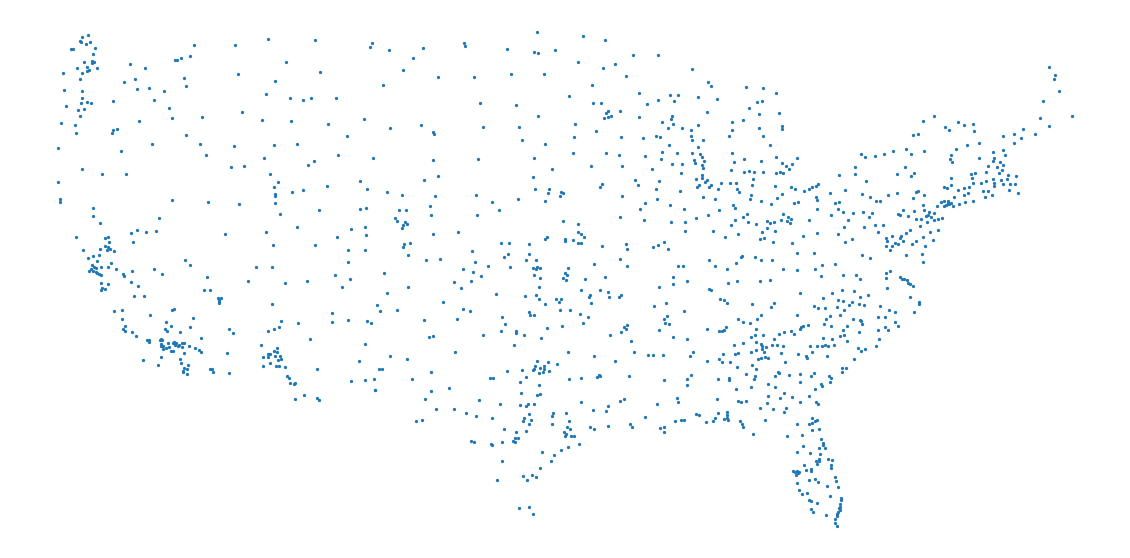

In [0]:
%python
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

ax.scatter(pd_airports_df['long'], pd_airports_df['lat'], s=5)
ax.axis('off')

plt.show()

In [0]:
%python
flights_df = spark.sql("""
    SELECT airlines.origin, airlines.dest, ad1.lat origin_lat, ad1.long origin_long, ad2.lat dest_lat, ad2.long dest_long
    FROM airlines
    INNER JOIN airports_data ad1 -- have to sacrifice losing a few iata airports
      ON airlines.ORIGIN = ad1.IATA
    INNER JOIN airports_data ad2 -- have to sacrifice losing a few iata airports
      ON airlines.dest = ad2.IATA
""")
flights_df.createOrReplaceTempView("flights")
flights_df.display()

origin,dest,origin_lat,origin_long,dest_lat,dest_long
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156
FSM,MEM,35.33660125732422,-94.36740112304688,35.04240036010742,-89.97669982910156


In [0]:
%python
import geopandas as gpd
from shapely.geometry import LineString


pd_flights_df = flights_df.toPandas().sample(10000) # we just need a random sample of 10,000 flights for the visual, else it's too ridiculous
geometry = [LineString([[pd_flights_df.iloc[i]['origin_long'], pd_flights_df.iloc[i]['origin_lat']], [pd_flights_df.iloc[i]['dest_long'], pd_flights_df.iloc[i]['dest_lat']]]) for i in range(pd_flights_df.shape[0])]
routes = gpd.GeoDataFrame(pd_flights_df, geometry=geometry, crs='EPSG:4326')
print(routes)

       origin dest  origin_lat  origin_long   dest_lat   dest_long  \
61162     MEM  JAN   35.042400   -89.976700  32.311199  -90.075897   
61277     MEM  CHA   35.042400   -89.976700  35.035301  -85.203796   
92519     CVG  HSV   39.048801   -84.667801  34.637199  -86.775101   
85831     CLE  FLL   41.411701   -81.849800  26.072599  -80.152702   
331489    BNA  MDW   36.124500   -86.678200  41.785999  -87.752403   
...       ...  ...         ...          ...        ...         ...   
259964    DFW  SAT   32.896801   -97.038002  29.533701  -98.469803   
194000    SEA  SLC   47.449001  -122.308998  40.788399 -111.977997   
124244    DCA  LGA   38.852100   -77.037697  40.777199  -73.872597   
352567    IAD  PHX   38.944500   -77.455803  33.434299 -112.012001   
409827    DEN  MCO   39.861698  -104.672997  28.429399  -81.308998   

                                                 geometry  
61162   LINESTRING (-89.97670 35.04240, -90.07590 32.3...  
61277   LINESTRING (-89.97670 35.04240,

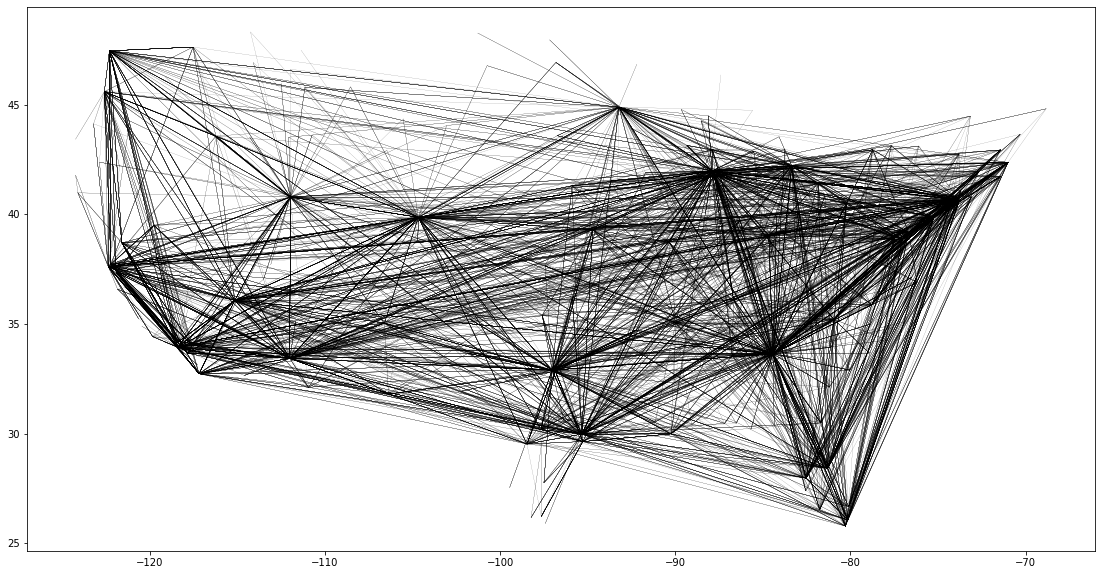

In [0]:
fig = plt.figure()
ax = plt.axes()

fig.set_size_inches(20, 10)
# ax.patch.set_facecolor('black')

routes.plot(ax=ax, color='black', linewidth=0.1)

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')

plt.show()